## <center>Topic Modelling with BERTopic</center>

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bertopic import BERTopic
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

c:\Users\ad1328\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

In [2]:
archives_df = pd.read_csv('data/archives.csv')
articles_df = pd.read_csv('data/articles.csv')

In [3]:
# Check the shape of the dataframes
row_archive, column_archive = archives_df.shape
row_article, column_article = articles_df.shape

print(f"Archives: {row_archive} volumes")
print(f"Articles: {row_article}")

# Display the first row of articles_df
display(articles_df.head(1))

# Make a copy of the 'abstract' column to 'abstract_feature' and convert to lowercase
articles_df["abstract_feature"] = articles_df["abstract"].str.lower()

# Print sample rows with NaN values in 'abstract_feature'
na_df = articles_df[articles_df['abstract_feature'].isnull()]
print(f'Rows count with abstract value = NaN: {na_df.shape}')
display(na_df.head(5))

# Remove rows with NaN values in 'abstract_feature'
articles_df = articles_df.dropna(subset=['abstract_feature'])

# Create a new dataframe where 'abstract_feature' contains "none available"
none_available_df = articles_df[articles_df['abstract_feature'].str.contains("none available")]

# Ensure the display is not truncated
pd.set_option('display.max_colwidth', None)

# Show only 'article_url' and 'abstract' columns
display(none_available_df[["article_url", "abstract"]])
print(f'Rows count with abstract value = none available: {none_available_df.shape}')

# Remove rows where the abstract text contains "none available"
articles_df = articles_df[articles_df['abstract_feature'].str.contains("none available") == False]

# Display the first row of the cleaned dataframe
display(articles_df.head(1))
print(articles_df.shape)


Archives: 351 volumes
Articles: 2665


,article_url,title,doi,publication_date,author,abstract,archive_url,import_date
0,https://firstmonday.org/ojs/index.php/fm/artic...,Beyond portals and gifts: Towards a bottom-up ...,https://doi.org/10.5210/fm.v4i1.639,1999-01-04,Felix Stalder,The Internet is haunted by its own promise: t...,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 17:08:44


Rows count with abstract value = NaN: (1293, 9)


,article_url,title,doi,publication_date,author,abstract,archive_url,import_date,abstract_feature
277,https://firstmonday.org/ojs/index.php/fm/artic...,NaN,NaN,1900-01-01,NaN,NaN,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 09:55:14,NaN
310,https://firstmonday.org/ojs/index.php/fm/artic...,NaN,NaN,1900-01-01,NaN,NaN,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 09:55:24,NaN
511,https://firstmonday.org/ojs/index.php/fm/artic...,FM Interviews: McKenzie Wark,https://doi.org/10.5210/fm.v9i12.1199,2004-12-06,Edward Valauskas,NaN,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 20:14:19,NaN
616,https://firstmonday.org/ojs/index.php/fm/artic...,Dispute resolution without borders: Some impli...,https://doi.org/10.5210/fm.v11i2.1313,2006-02-06,Ethan Katsh,NaN,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 20:16:08,NaN
861,https://firstmonday.org/ojs/index.php/fm/artic...,NaN,NaN,1900-01-01,NaN,NaN,https://firstmonday.org/ojs/index.php/fm/issue...,2025-01-22 09:58:36,NaN


,article_url,abstract
1,https://firstmonday.org/ojs/index.php/fm/article/view/640,None available.
9,https://firstmonday.org/ojs/index.php/fm/article/view/652,None available.
10,https://firstmonday.org/ojs/index.php/fm/article/view/651,None available.
11,https://firstmonday.org/ojs/index.php/fm/article/view/657,None available.
19,https://firstmonday.org/ojs/index.php/fm/article/view/662,None available.
...,...,...
853,https://firstmonday.org/ojs/index.php/fm/article/view/1923,None Available
855,https://firstmonday.org/ojs/index.php/fm/article/view/1925,None Available
858,https://firstmonday.org/ojs/index.php/fm/article/view/1921,None Available
878,https://firstmonday.org/ojs/index.php/fm/article/view/1953,None Available


Rows count with abstract value = none available: (141, 9)


,article_url,title,doi,publication_date,author,abstract,archive_url,import_date,abstract_feature
0,https://firstmonday.org/ojs/index.php/fm/article/view/639,Beyond portals and gifts: Towards a bottom-up net-economy,https://doi.org/10.5210/fm.v4i1.639,1999-01-04,Felix Stalder,"The Internet is haunted by its own promise: the liberation of information. Typically, this promise is a strange hybrid of 60's progressive libertarianism and 90's aggressive venture capitalism. The slogan ""information wants to be free"" still shapes the dynamics of on-line content consumption and production. The results: America Online and Netscape merge and the high-tech gift economy flourishes.",https://firstmonday.org/ojs/index.php/fm/issue/view/100,2025-01-22 17:08:44,"the internet is haunted by its own promise: the liberation of information. typically, this promise is a strange hybrid of 60's progressive libertarianism and 90's aggressive venture capitalism. the slogan ""information wants to be free"" still shapes the dynamics of on-line content consumption and production. the results: america online and netscape merge and the high-tech gift economy flourishes."


(1231, 9)


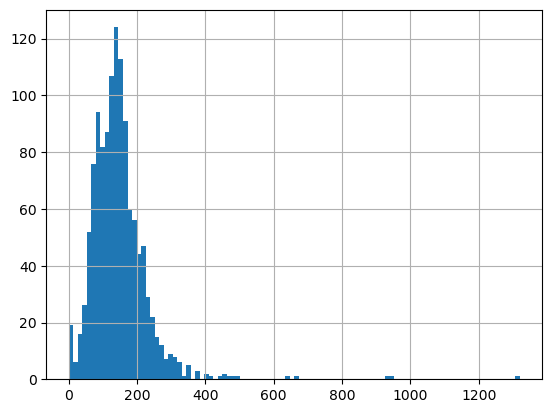

In [4]:


# create new column 'abstract_length' from abstract_feature which contain count of words in abstract
articles_df['abstract_length'] = articles_df['abstract_feature'].str.split().str.len()

# display histogram of 'abstract_length'
articles_df['abstract_length'].hist(bins=100)
plt.show()


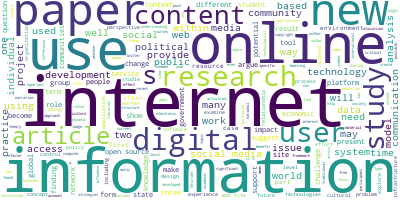

In [5]:
# create a word of cloud of the abstract_feature
from wordcloud import WordCloud

# Join the different processed abstracts together.
long_string = ','.join(list(articles_df['abstract_feature'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()



In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic import BERTopic
from hdbscan import HDBSCAN

# Download stopwords and wordnet
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)                         # Remove non-alpha
    text = text.lower()
    words = text.split()
    words = [w for w in words if w not in stop_words]               # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]                # Lemmatize
    return ' '.join(words)

# Fill NaN and preprocess
articles_df['abstract_feature'] = articles_df['abstract_feature'].fillna('')
articles_df['abstract_feature'] = articles_df['abstract_feature'].apply(preprocess_text)

abstracts = articles_df['abstract_feature'].tolist()


# Load the SentenceTransformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Vectorizer with no built-in stopword removal, since we do it above
vectorizer_model = TfidfVectorizer(
    stop_words=None,       # Already removed in preprocess
    max_features=10000,
    ngram_range=(1, 3)
)

# Customize HDBSCAN for fewer outliers
hdbscan_model = HDBSCAN(
    min_cluster_size=5,
    min_samples=1,
    cluster_selection_epsilon=0.0,  # adjust as needed
    cluster_selection_method='eom'
)

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    nr_topics="auto"  # or an integer
)

topics, probabilities = topic_model.fit_transform(abstracts)

topic_df = topic_model.get_topic_info()
display(topic_df[["Topic", "Count", "Name", "Representation"]])

# If too many small topics exist or you want to reduce total topics further
# new_topics, new_probs = topic_model.reduce_topics(abstracts, probabilities, nr_topics=20)
# topic_df = topic_model.get_topic_info()
# display(topic_df[["Topic", "Count", "Name", "Representation"]])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ad1328\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ad1328\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Topic,Count,Name,Representation
0,-1,261,-1_digital_data_user_social,"[digital, data, user, social, information, inequality, paper, icts, internet, political]"
1,0,430,0_student_internet_medium_political,"[student, internet, medium, political, rural, social, digital, technology, bot, divide]"
2,1,95,1_library_museum_journal_publishing,"[library, museum, journal, publishing, scholarly, public library, access, museum library, collection, preservation]"
3,2,76,2_open source_floss_software_source,"[open source, floss, software, source, copyright, linux, open, source software, open source software, patent]"
4,3,33,3_pandemic_covid_covid pandemic_health,"[pandemic, covid, covid pandemic, health, social, crisis, infodemic, brazilian, exposure, conspiracy]"
5,4,24,4_search_engine_search engine_query,"[search, engine, search engine, query, web, page, personalization, web search, personalization feature, usability]"
6,5,21,5_bb ecommerce_bb_business_internet business,"[bb ecommerce, bb, business, internet business, ecommerce, consumer, cost, internet business model, internet, business model]"
7,6,19,6_urban_screen_city_space,"[urban, screen, city, space, spatial, urban screen, art, public space, anchoring, urban space]"
8,7,17,7_privacy_poll_opinion_security,"[privacy, poll, opinion, security, tm, privacy issue, online privacy, opinion poll, recommender system, recommender]"
9,8,16,8_music_music industry_artist_industry,"[music, music industry, artist, industry, mobile internet, japan, music internet, digital music, label, mobile]"


In [13]:
# Visualize the topics
topic_model.visualize_topics()

In [8]:
topic_model.visualize_distribution(probabilities)

In [9]:
topic_model.visualize_hierarchy()

In [10]:
topic_model.visualize_barchart()

In [11]:
topic_model.visualize_heatmap()

In [21]:
# -------------------------------
# Single-cell example (compatible with older BERTopic):
# Generating & Visualizing Hierarchical Topics, then Reducing Topic Count
# -------------------------------
import plotly.io as pio

# 1. Generate hierarchical topics (for visualization only in older versions)
hierarchical_topics = topic_model.hierarchical_topics(abstracts)

# 2. Visualize the topic hierarchy
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show()

# 3. Merge/Reduce topics using 'reduce_topics' rather than 'merge_topics'
#    'reduce_topics()' merges topics down to a specified 'nr_topics'
#    without requiring hierarchical_topics parameter.
new_topics, new_probs = topic_model.reduce_topics(
    documents=abstracts,
    probabilities=probabilities,  # ensure you have 'probabilities' from fit_transform
    nr_topics=10                  # change this number to the desired final topics
)

# 4. See the updated topics
merged_info = topic_model.get_topic_info()
print(merged_info[["Topic", "Count", "Name", "Representation"]])


100%|██████████| 41/41 [00:00<00:00, 246.75it/s]


TypeError: BERTopic.reduce_topics() got an unexpected keyword argument 'documents'